See how to use Shor's algorithm to factor 15 here:    <b><a href="https://portal.quantumrings.com/doc/Shors.html">Shor15</a></b>

<i><b>Source code to factorize 15</b></i>

Note: Be sure to use your API token and your account name.

Step 1. Import the required modules and obtain the backend

In [1]:
pip install QuantumRingsLib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.4 MB/s eta 0:00:00


In [2]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from matplotlib import pyplot as plt
import numpy as np
import math


provider = QuantumRingsProvider(
    token='rings-128.6GOE0LCn1c1QA5EQGIw9fhuDlxnzMlty',
    name='anindaastuti@gmail.com'
)
backend = provider.get_backend("scarlet_quantum_rings")
shots = 1024

provider.active_account()

{'name': 'anindaastuti@gmail.com',
 'token': 'rings-128.6GOE0LCn1c1QA5EQGIw9fhuDlxnzMlty',
 'max_qubits': '128'}

Step 2. Define the core methods

In [3]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cu1(  -math.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()
    return

def plot_histogram (counts, title=""):
    """
    Plots the histogram of the counts

    Args:

        counts (dict):
            The dictionary containing the counts of states

        titles (str):
            A title for the graph.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize =(15, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return

Step 3. Perform the algorithm

In [4]:
# Shor’s algorithm to factorize 15 using 7^x mod 15.
numberofqubits = 7
shots = 1024

q = QuantumRegister(numberofqubits , 'q')
c = ClassicalRegister(4 , 'c')
qc = QuantumCircuit(q, c)

# Initialize source and target registers
qc.h(0)
qc.h(1)
qc.h(2)
qc.x(6)
qc.barrier()

# Modular exponentiation 7^x mod 15
qc.cx(q[2],q[4] )
qc.cx(q[2],q[5] )
qc.cx(q[6],q[4] )
qc.ccx(q[1],q[5],q[3] )
qc.cx(q[3],q[5] )
qc.ccx(q[1],q[4],q[6] )
qc.cx(q[6],q[4] ) #
qc.barrier()

# IQFT. Refer to implementation from earlier examples
iqft_cct (qc, q, 3)

# Measure
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])

# Draw the circuit
qc.draw('mpl')

       ┌───┐ ╎                                     ╎ ┌───┐               »
q[0]: ■┤ H ├─╎─────────────────────────────────────╎─┤ H ├───────■───────»
       ├───┤ ╎                                     ╎ └───┘┌──────┴──────┐»
q[1]: ■┤ H ├─╎──────────────────■─────────■────────╎──────┤ U1(-pi/2)   ├»
       ├───┤ ╎                  │         │        ╎      └─────────────┘»
q[2]: ■┤ H ├─╎───■────■─────────│─────────│────────╎─────────────────────»
       └───┘ ╎   │    │       ┌─┴─┐       │        ╎                     »
q[3]: ■──────╎───│────│───────┤ X ├──■────│────────╎─────────────────────»
             ╎ ┌─┴─┐  │  ┌───┐└─┬─┘  │    │  ┌───┐ ╎                     »
q[4]: ■──────╎─┤ X ├──│──┤ X ├──│────│────■──┤ X ├─╎─────────────────────»
             ╎ └───┘┌─┴─┐└─┬─┘  │  ┌─┴─┐  │  └─┬─┘ ╎                     »
q[5]: ■──────╎──────┤ X ├──│────■──┤ X ├──│────│───╎─────────────────────»
       ┌───┐ ╎      └───┘  │       └───┘┌─┴─┐  │   ╎                     »
q[6]: ■┤ X ├─╎───────────

The circuit to factor 15 shown above.

Job Running
Job Done.
Ending Job Monitor


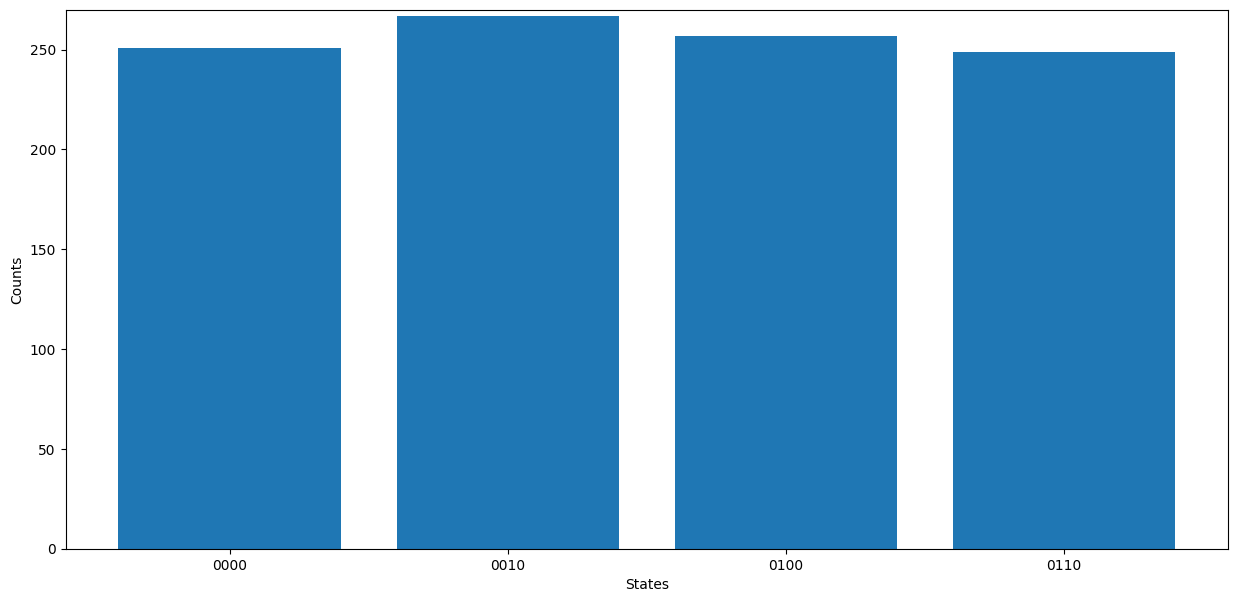

In [5]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts_15 = result.get_counts()

# visualize
plot_histogram(counts_15)

#clean up
del q, c, qc
del result
del job

In [6]:
from fractions import Fraction
from math import gcd

def find_r_from_histogram(counts, Q):
    """
    Compute the candidate period r using the measurement outcome histogram.
    This function processes a dictionary of counts where keys are binary strings
    of quantum measurement outcomes. It converts these keys to integer C values,
    computes the best rational approximations of C/Q with denominators not exceeding Q,
    and collects the unique denominators as candidates for r. The function returns
    the smallest candidate r that is strictly greater than 1. If no such candidate
    exists, it returns None.
    Parameters:
        counts (dict): A dictionary where keys are measurement outcomes represented
                       as binary strings.
        Q (int): The denominator used to form the fraction C/Q, typically representing
                 the size of the quantum state space.
    Returns:
        int or None: The smallest candidate period r (greater than 1), or None if no candidate is found.
    """
    C_values = [int(bitstr, 2) for bitstr in counts.keys()]
    fractions = [Fraction(C, Q).limit_denominator(Q) for C in C_values]
    denominators = [frac.denominator for frac in fractions]
    r_candidates = sorted(set(denominators))

    print(f"C_values: {C_values}")
    print(f"fractions: {fractions}")
    print(f"denominators: {denominators}")
    print(f"r_candidates: {r_candidates}")

    for r in r_candidates:
        if r > 1:
            return r
    return None

# 測試範例: N = 15, a = 7, 4 個 qubits
Q = 2**4
r = find_r_from_histogram(counts_15, Q)
print(f"Fount r: {r}")

C_values: [0, 2, 4, 6]
fractions: [Fraction(0, 1), Fraction(1, 8), Fraction(1, 4), Fraction(3, 8)]
denominators: [1, 8, 4, 8]
r_candidates: [1, 4, 8]
Fount r: 4


In [7]:
# Compute factors
N=15
a=7
factor1 = gcd(a**(r//2) + 1, N)
factor2 = gcd(a**(r//2) - 1, N)
print(f"Factors: {factor1}, {factor2}")

Factors: 5, 3


In [8]:
numberofqubits = 5  # Menambah jumlah qubit
shots = 1024

#untuk modulus 21, Anda memerlukan sekitar 5 qubit untuk representasi fase (karena  \log_2(21) \approx 4.4 , jadi dibutuhkan 5 qubit).

q = QuantumRegister(numberofqubits , 'q')
c = ClassicalRegister(5 , 'c')  # Ubah jumlah classical bits
qc = QuantumCircuit(q, c)

# Inisialisasi qubit
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)  # Tambahkan qubit untuk modulus yang lebih besar
qc.x(4)  # Qubit tambahan jika perlu
qc.barrier()

# Eksponensiasi modular 5^x mod 21 (Harus dimodifikasi sesuai dengan modul baru)
qc.cx(q[2], q[4])  # Menggunakan qubit yang valid
qc.cx(q[2], q[3])  # Perbaiki ke qubit yang valid
qc.cx(q[0], q[4])  # Sesuaikan dengan register yang valid
qc.ccx(q[1], q[3], q[2])  # Perbaiki gate Toffoli sesuai dengan qubit yang ada
qc.cx(q[2], q[3])  # Sesuaikan dengan qubit yang valid
qc.ccx(q[1], q[4], q[0])  # Sesuaikan gate Toffoli
qc.cx(q[4], q[3])  # Sesuaikan gate CNOT
qc.barrier()

# IQFT untuk memproses hasil
iqft_cct(qc, q, 4)

# Pengukuran
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])
qc.measure(q[3], c[3])
qc.measure(q[4], c[4])

# Gambar sirkuit
qc.draw('mpl')

       ┌───┐ ╎                          ┌───┐      ╎ ┌───┐               »
q[0]: ■┤ H ├─╎─────────────■────────────┤ X ├──────╎─┤ H ├───────■───────»
       ├───┤ ╎             │            └─┬─┘      ╎ └───┘┌──────┴──────┐»
q[1]: ■┤ H ├─╎─────────────│────■─────────■────────╎──────┤ U1(-pi/2)   ├»
       ├───┤ ╎             │  ┌─┴─┐       │        ╎      └─────────────┘»
q[2]: ■┤ H ├─╎───■────■────│──┤ X ├──■────│────────╎─────────────────────»
       ├───┤ ╎   │  ┌─┴─┐  │  └─┬─┘┌─┴─┐  │  ┌───┐ ╎                     »
q[3]: ■┤ H ├─╎───│──┤ X ├──│────■──┤ X ├──│──┤ X ├─╎─────────────────────»
       ├───┤ ╎ ┌─┴─┐└───┘┌─┴─┐     └───┘  │  └─┬─┘ ╎                     »
q[4]: ■┤ X ├─╎─┤ X ├─────┤ X ├────────────■────■───╎─────────────────────»
       └───┘ ╎ └───┘     └───┘                     ╎                     »
c: 5/ ■══════════════════════════════════════════════════════════════════»
                                                                         »
«                        

Job Running
Job Done.
Ending Job Monitor


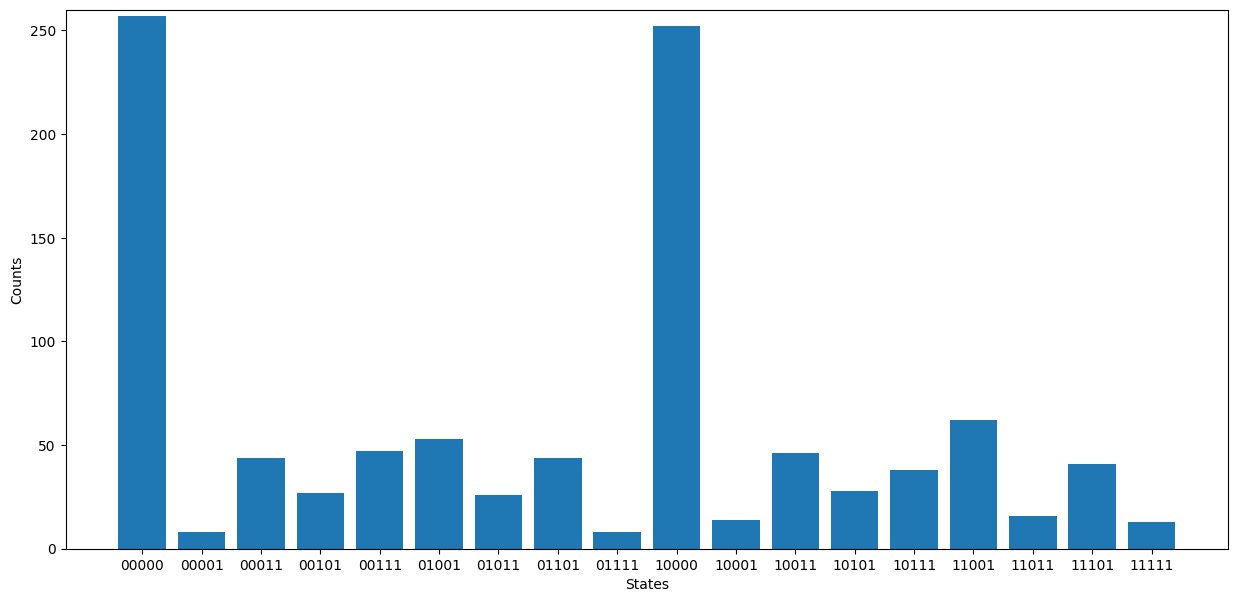

In [9]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts= result.get_counts()

# visualize
plot_histogram(counts)

#clean up
del q, c, qc
del result
del job

In [10]:
from fractions import Fraction
from math import gcd

def find_r_from_histogram(counts, Q):
    """
    Compute the candidate period r using the measurement outcome histogram.
    This function processes a dictionary of counts where keys are binary strings
    of quantum measurement outcomes. It converts these keys to integer C values,
    computes the best rational approximations of C/Q with denominators not exceeding Q,
    and collects the unique denominators as candidates for r. The function returns
    the smallest candidate r that is strictly greater than 1. If no such candidate
    exists, it returns None.
    Parameters:
        counts (dict): A dictionary where keys are measurement outcomes represented
                       as binary strings.
        Q (int): The denominator used to form the fraction C/Q, typically representing
                 the size of the quantum state space.
    Returns:
        int or None: The smallest candidate period r (greater than 1), or None if no candidate is found.
    """
    C_values = [int(bitstr, 2) for bitstr in counts.keys()]
    fractions = [Fraction(C, Q).limit_denominator(Q) for C in C_values]
    denominators = [frac.denominator for frac in fractions]
    r_candidates = sorted(set(denominators))

    print(f"C_values: {C_values}")
    print(f"fractions: {fractions}")
    print(f"denominators: {denominators}")
    print(f"r_candidates: {r_candidates}")

    for r in r_candidates:
        if r > 1:
            return r
    return None

# 測試範例: N = 15, a = 7, 4 個 qubits
Q = 2**4
r = find_r_from_histogram(counts, Q)
print(f"Fount r: {r}")

C_values: [0, 1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29, 31]
fractions: [Fraction(0, 1), Fraction(1, 16), Fraction(3, 16), Fraction(5, 16), Fraction(7, 16), Fraction(9, 16), Fraction(11, 16), Fraction(13, 16), Fraction(15, 16), Fraction(1, 1), Fraction(17, 16), Fraction(19, 16), Fraction(21, 16), Fraction(23, 16), Fraction(25, 16), Fraction(27, 16), Fraction(29, 16), Fraction(31, 16)]
denominators: [1, 16, 16, 16, 16, 16, 16, 16, 16, 1, 16, 16, 16, 16, 16, 16, 16, 16]
r_candidates: [1, 16]
Fount r: 16


In [11]:
# Compute factors
N=21
a=5
factor1 = gcd(a**(r//2) + 1, N)
factor2 = gcd(a**(r//2) - 1, N)
print(f"Factors: {factor1}, {factor2}")

Factors: 1, 3


A plot of the execution results is shown above. Compare this with the calculated values.

Footnotes

[1] This section is based on [10], [14], and [16].

[2] https://research.ibm.com/blog/factor-15-shors-algorithm

[3] https://en.wikipedia.org/wiki/Integer_factorization_records#Records_for_efforts_by_quantum_computers